In [ ]:
# --- Sistema & reproducibilidad
import os, math, logging, warnings, random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- TensorFlow / Keras
import tensorflow as tf
tf.random.set_seed(SEED)
from tensorflow import keras
from tensorflow.keras import layers

# (Opcional) evitar que TF consuma toda la GPU
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception as e:
    print("TF GPU config:", e)

# --- scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Calendarios de feriados
import holidays
# Según versión: holidays.country_holidays('AR') o holidays.AR()
try:
    ar_holidays = holidays.country_holidays('AR')
except Exception:
    ar_holidays = holidays.AR()

# --- Modelado de series y HPO
from neuralprophet import NeuralProphet
import optuna
from optuna.exceptions import TrialPruned

# --- Logging & warnings
logging.getLogger("NP").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)

# --- (Colab) Google Drive
from google.colab import drive
# drive.mount("/content/drive")  # Descomenta cuando lo necesites

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Leer csv
try:
    df = pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')
    print("CSV file loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure the file path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
CSV file loaded successfully!


In [ ]:
df

,fecha,volumen_DSP,volumen_NFP,volumen_NFC
0,2022-04-01,8250.661415,2812.930519,9617.223206
1,2022-04-02,6217.523570,2646.149141,8787.202670
2,2022-04-03,6930.748854,1241.374704,9359.098394
3,2022-04-04,5653.462986,2040.678695,10815.788281
4,2022-04-05,8928.674663,2990.599222,10397.908453
...,...,...,...,...
1097,2025-04-02,5233.009932,1790.127405,13128.939463
1098,2025-04-03,5103.432767,2153.394810,18780.474280
1099,2025-04-04,8590.668848,2454.637897,14873.124193
1100,2025-04-05,6421.951011,1604.036352,15573.881240


In [ ]:
!pip install optuna --quiet
!pip install neuralprophet optuna holidays --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install neuralprophet optuna holidays --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 75.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is inco

### N PROPHET

In [ ]:
# --------- 0) Imports y setup ----------


# ======== 1) Parámetros del flujo (EDITAR A GUSTO) ========
# CSV_PATH       = "/mnt/data/merged_df_clean.csv"
DATE_COL       = "fecha"        # Si ya tenés 'ds' en el CSV, poné DATE_COL="ds"
TARGET_COL     = "volumen_NFC"  # Cambiá a la serie objetivo (p.ej.: 'volumen_DSP', 'volumen_NFC')
FREQ           = "D"            # Frecuencia temporal (D = diaria)
TEST_DAYS      = 90             # tamaño holdout test
VAL_DAYS       = 90             # tamaño holdout validación
H              = 7              # horizonte multi-step
N_TRIALS       = 25             # cantidad de trials Optuna

# ======== 2) Carga y preparación desde CSV ========
df_raw = df = pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')

# Normalizo nombre de fecha -> 'ds'
if DATE_COL in df_raw.columns and DATE_COL != "ds":
    df_raw = df_raw.rename(columns={DATE_COL: "ds"})
elif "ds" not in df_raw.columns:
    raise ValueError("No se encontró columna de fecha. Esperaba 'fecha' o 'ds' en el CSV.")

# Parseo, orden y reindex a calendario continuo
df_raw["ds"] = pd.to_datetime(df_raw["ds"])
df_raw = df_raw.sort_values("ds").set_index("ds")

# Validación target
if TARGET_COL not in df_raw.columns:
    raise ValueError(f"No se encontró la columna objetivo '{TARGET_COL}'. Columnas: {df_raw.columns.tolist()}")

# Reindex a frecuencia diaria continua
full_range = pd.date_range(df_raw.index.min(), df_raw.index.max(), freq=FREQ)
df = df_raw.reindex(full_range)

# Separar target y exógenas
regressor_candidates = [c for c in df.columns if c != TARGET_COL]

# Relleno exógenas numéricas (forward-fill). NO relleno 'y'.
for c in regressor_candidates:
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = df[c].ffill()

# Volver a columnas
df = df.reset_index().rename(columns={"index": "ds"})

# Armo dataset de trabajo
num_cols = [c for c in regressor_candidates if pd.api.types.is_numeric_dtype(df[c])]
regressor_cols = num_cols  # si querés elegir manualmente, reemplazá esta lista

work_df = df[["ds", TARGET_COL] + regressor_cols].copy()
work_df = work_df.rename(columns={TARGET_COL: "y"})
work_df = work_df.dropna(subset=["y"]).reset_index(drop=True)

# ======== 3) Split temporal Train / Val / Test ========
n = len(work_df)
if (VAL_DAYS + TEST_DAYS + H) >= n:
    raise ValueError("Muy pocos datos para VAL_DAYS/TEST_DAYS/H. Reducí alguno(s).")

train_end = n - (VAL_DAYS + TEST_DAYS)
val_end   = n - TEST_DAYS

train_df = work_df.iloc[:train_end].copy()
val_df   = work_df.iloc[train_end:val_end].copy()
test_df  = work_df.iloc[val_end:].copy()

print(f"Split sizes -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")
print("Rango fechas ->",
      f"train[{train_df['ds'].min().date()} .. {train_df['ds'].max().date()}],",
      f"val[{val_df['ds'].min().date()} .. {val_df['ds'].max().date()}],",
      f"test[{test_df['ds'].min().date()} .. {test_df['ds'].max().date()}]")

def split_regressors_by_future_availability(train_df, val_df, regressor_cols, H, FREQ):
    """
    Devuelve (future_regs, lagged_regs).
    future_regs: exógenas que tienen cobertura completa y sin NaN en las H fechas
                 posteriores a la última fecha de train_df.
    lagged_regs: el resto (no tienen datos futuros o tienen NaN).
    """
    if not regressor_cols:
        return [], []

    last_train = train_df["ds"].max()
    fut_index  = pd.date_range(last_train + pd.tseries.frequencies.to_offset(FREQ),
                               periods=H, freq=FREQ)

    # Reindexar val_df a las H fechas futuras esperadas
    val_future = val_df.set_index("ds").reindex(fut_index)

    future_regs, lagged_regs = [], []
    for c in regressor_cols:
        if c not in val_future.columns:
            lagged_regs.append(c)
            continue
        col = val_future[c]
        if (col.notna().all()):  # cobertura completa y sin NaN en las H fechas
            future_regs.append(c)
        else:
            lagged_regs.append(c)

    return future_regs, lagged_regs

# ---- ejecutalo una vez, antes de Optuna:
future_regressors, lagged_regressors = split_regressors_by_future_availability(
    train_df, val_df, regressor_cols, H, FREQ
)
print("future_regressors:", future_regressors)
print("lagged_regressors:", lagged_regressors)

def split_future_vs_lagged_for_trial(train_df, horizon_df, candidate_future_regs, H, FREQ):
    """
    Dado un conjunto de 'candidate_future_regs', verifica si en 'horizon_df'
    hay cobertura completa y sin NaN para las H fechas posteriores a last_train.
    Devuelve (future_regs_ok, lagged_regs_trial) para usar *solo en esta trial*.
    """
    if not candidate_future_regs:
        return [], []

    last_train = train_df["ds"].max()
    fut_idx = pd.date_range(last_train + pd.tseries.frequencies.to_offset(FREQ),
                            periods=H, freq=FREQ)
    hz = horizon_df.set_index("ds").reindex(fut_idx)

    future_ok, lagged_now = [], []
    for c in candidate_future_regs:
        if c not in hz.columns:
            lagged_now.append(c); continue
        col = hz[c]
        if col.notna().all():
            future_ok.append(c)
        else:
            lagged_now.append(c)
    return future_ok, lagged_now


ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


Split sizes -> train: 922, val: 90, test: 90
Rango fechas -> train[2022-04-01 .. 2024-10-08], val[2024-10-09 .. 2025-01-06], test[2025-01-07 .. 2025-04-06]
future_regressors: ['volumen_DSP', 'volumen_NFP']
lagged_regressors: []


In [ ]:
# ======== 4) Guardas previas para evitar NaN en trials ========
assert train_df["y"].notna().all(), "Hay NaN en y dentro de train_df"
assert val_df["y"].notna().all(),   "Hay NaN en y dentro de val_df"
assert len(train_df) > 5*H,         f"Pocos datos en train_df para H={H}"

if regressor_cols:
    for c in regressor_cols:
        assert train_df[c].notna().all(), f"NaN en exógena '{c}' en train_df"
        assert val_df[c].notna().all(),   f"NaN en exógena '{c}' en val_df"

In [ ]:
# ======== 5) Helpers NeuralProphet (entrenamiento / futuro / evaluación) ========
def train_neuralprophet(df_in, future_regs, lagged_regs, params, h):
    """Entrena NP forzando n_forecasts=h. Declara future y lagged regressors según disponibilidad."""
    p = params.copy()
    p["n_forecasts"] = h

    m = NeuralProphet(
        n_lags=p.get("n_lags", 14),
        n_forecasts=p.get("n_forecasts", h),
        learning_rate=p.get("learning_rate", 0.01),
        epochs=p.get("epochs", 100),
        batch_size=p.get("batch_size", 32),
        n_changepoints=p.get("n_changepoints", 10),
        changepoints_range=p.get("changepoints_range", 0.8),
    )

    # Regressors conocidos en futuro
    for c in (future_regs or []):
        m.add_future_regressor(c, normalize="auto")

    # Regressors solo históricos (no requieren valores futuros)
    if lagged_regs:
        m.add_lagged_regressor(names=lagged_regs, normalize="auto")

    m.fit(df_in, freq=FREQ, progress="bar")
    return m


def _freq_offset(freq_str):
    # Devuelve el offset de pandas para avanzar una unidad de frecuencia
    return pd.tseries.frequencies.to_offset(freq_str)

def make_future_with_exog(model, ctx_df, horizon_df, future_regs, h):
    """
    Future DF = histórico (ctx_df) + h pasos.
    Solo necesita regressors_df para las columnas en future_regs.
    """
    if not future_regs:
        # No hay regresores futuros → invocación simple
        return model.make_future_dataframe(
            df=ctx_df, periods=h, n_historic_predictions=True
        )

    last_hist = ctx_df["ds"].max()
    start     = last_hist + pd.tseries.frequencies.to_offset(FREQ)
    fut_index = pd.date_range(start=start, periods=h, freq=FREQ)

    hz = horizon_df.set_index("ds").reindex(fut_index)

    missing_cols = [c for c in future_regs if c not in hz.columns]
    if missing_cols:
        raise ValueError(f"En horizon_df faltan columnas exógenas futuras: {missing_cols}")

    regressors_df = hz[future_regs].copy()
    miss = regressors_df.isna().sum().sum()
    if miss > 0:
        raise ValueError(
            f"Faltan {int(miss)} valores futuros en {future_regs}. Completalos o muévelas a lagged."
        )

    future = model.make_future_dataframe(
        df=ctx_df,
        periods=h,
        n_historic_predictions=True,
        regressors_df=regressors_df.reset_index().rename(columns={"index": "ds"})
    )
    return future


def eval_model_h(model, future_df, horizon_df, h, df_hist_context):
    """
    Alinea correctamente: para cada fecha futura t+i usa la columna yhat{i+1} de ESA fila.
    Devuelve (rmse_raw, y_true, y_pred, target_dates).
    """
    fcst = model.predict(future_df).sort_values("ds")
    last_hist = df_hist_context["ds"].max()

    # Fechas exactas del horizonte
    target_dates = pd.date_range(
        last_hist + pd.tseries.frequencies.to_offset(FREQ),
        periods=h, freq=FREQ
    )

    # Extraer y_pred alineado por fila/columna
    y_pred = []
    for i, d in enumerate(target_dates, start=1):
        row = fcst.loc[fcst["ds"] == d]
        col = f"yhat{i}"
        if not row.empty and col in row.columns:
            y_pred.append(row.iloc[0][col])
        else:
            y_pred.append(np.nan)
    y_pred = np.asarray(y_pred, dtype=float)

    # y_true alineado por fechas exactas
    hz = horizon_df.set_index("ds").reindex(target_dates)
    y_true = hz["y"].to_numpy(dtype=float)

    rmse_raw = float(np.sqrt(np.nanmean((y_true - y_pred) ** 2)))
    return rmse_raw, y_true, y_pred, target_dates

In [ ]:
def check_future_coverage(horizon_df, last_hist_date, future_regs, H, FREQ, tag="VAL/TEST"):
    import pandas as pd
    if not future_regs:
        print(f"[{tag}] No hay future_regressors -> OK")
        return True
    fut_idx = pd.date_range(last_hist_date + pd.tseries.frequencies.to_offset(FREQ),
                            periods=H, freq=FREQ)
    hz = horizon_df.set_index("ds").reindex(fut_idx)
    missing_cols = [c for c in future_regs if c not in hz.columns]
    if missing_cols:
        print(f"[{tag}] Faltan columnas: {missing_cols}")
        return False
    miss = hz[future_regs].isna().sum()
    if miss.sum() > 0:
        print(f"[{tag}] NaN futuros por columna:\n{miss}")
        print(hz[future_regs].isna().any(axis=1).to_frame("fila_con_NaN").T)
        return False
    print(f"[{tag}] Cobertura completa de {future_regs} para H={H} → OK")
    return True

last_train_date = train_df["ds"].max()
ok_val  = check_future_coverage(val_df,  last_train_date, future_regressors, H, FREQ, tag="VAL")
ok_test = check_future_coverage(pd.concat([val_df.tail(1), test_df]).iloc[1:],  # solo por claridad; realmente importa TEST
                                val_df["ds"].max(), future_regressors, H, FREQ, tag="TEST")

[VAL] Cobertura completa de ['volumen_DSP', 'volumen_NFP'] para H=7 → OK
[TEST] Cobertura completa de ['volumen_DSP', 'volumen_NFP'] para H=7 → OK


In [ ]:
# ======== 6) Optuna: objective robusto (sin NaN) y optimización ========
def objective(trial):
    # Limitar n_lags según el tamaño de train (evita CTX > len(train))
    max_lags_cap = max(10, min(20, len(train_df)//4))  # p.ej. 20 o len/4, lo que sea menor
    params = {
        "n_lags": trial.suggest_int("n_lags", 7, max_lags_cap),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 5e-2, log=True),
        "epochs": trial.suggest_int("epochs", 50, 200, step=50),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
        "n_changepoints": trial.suggest_int("n_changepoints", 5, 20),
        "changepoints_range": trial.suggest_float("changepoints_range", 0.7, 0.95),
    }

    try:
        n_lags = int(params.get("n_lags", 14))
        CTX = max(n_lags, 14) + H
        if len(train_df) <= CTX:
            # En vez de prune, devolvemos un valor grande (trial COMPLETE)
            return 1e12

        # **Ajuste por trial**: si alguna future no tiene cobertura en VAL, la pasamos a lagged
        future_ok, lagged_now = split_future_vs_lagged_for_trial(
            train_df, val_df, future_regressors, H, FREQ
        )
        # lagged finales = lagged globales (si tenías) + las que en esta trial no tienen cobertura futura
        lagged_final = list(set((lagged_regressors or []) + lagged_now))

        # Entrenar en TRAIN
        model = train_neuralprophet(train_df, future_ok, lagged_final, params, H)

        # Contexto para validación (solo y + lagged; las future se pasan aparte)
        ctx_val = train_df.tail(CTX).dropna(subset=["y"] + lagged_final).reset_index(drop=True)
        if ctx_val.empty:
            return 1e12

        # Armar DF futuro (pasa solo las future_ok de esta trial)
        fut_val = make_future_with_exog(model, ctx_val, val_df, future_ok, h=H)

        # Métrica
        rmse_val, _, _ = eval_model_h(model, fut_val, val_df, h=H, df_hist_context=ctx_val)
        if not np.isfinite(rmse_val):
            return 1e12

        return float(rmse_val)

    except Exception as e:
        # Nunca NaN: valor grande pero finito
        print(f"[Trial COMPLETE with large value due to exception] {type(e).__name__}: {e}")
        return 1e12




In [ ]:
# ===== Optuna =====
study = optuna.create_study(direction="minimize", study_name=f"NP_{TARGET_COL}_H{H}")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

complete_trials = [t for t in study.trials if t.state.name == "COMPLETE" and np.isfinite(t.value)]
if not complete_trials:
    diag = pd.DataFrame([(t.number, t.state.name, t.value, t.params) for t in study.trials],
                        columns=["trial","state","value","params"])
    print("\n[Diagnóstico Optuna] Sin trials COMPLETAS:")
    print(diag)
    # Forzamos al menos tomar la menor entre las COMPLETE (inf) o PRUNED? -> mejor abortar con diagnóstico claro
    raise RuntimeError("No hay trials completadas con valor válido.")

best_trial  = min(complete_trials, key=lambda t: t.value)
best_params = best_trial.params
print("\nMejores hiperparámetros:", best_params)



[I 2025-10-19 13:24:52,287] A new study created in memory with name: NP_volumen_NFC_H7


  0%|          | 0/25 [00:00<?, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:25:01,139] Trial 0 finished with value: 1000000000000.0 and parameters: {'n_lags': 8, 'learning_rate': 0.006374240824541828, 'epochs': 50, 'batch_size': 32, 'n_changepoints': 16, 'changepoints_range': 0.9318223596825066}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:25:14,568] Trial 1 finished with value: 1000000000000.0 and parameters: {'n_lags': 11, 'learning_rate': 0.0012541389568779722, 'epochs': 150, 'batch_size': 64, 'n_changepoints': 16, 'changepoints_range': 0.9253755369365239}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:25:24,964] Trial 2 finished with value: 1000000000000.0 and parameters: {'n_lags': 19, 'learning_rate': 0.005534840036243286, 'epochs': 100, 'batch_size': 64, 'n_changepoints': 20, 'changepoints_range': 0.9252209647527839}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:25:48,380] Trial 3 finished with value: 1000000000000.0 and parameters: {'n_lags': 12, 'learning_rate': 0.0032339062480898524, 'epochs': 150, 'batch_size': 32, 'n_changepoints': 5, 'changepoints_range': 0.7373029855269375}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:26:17,464] Trial 4 finished with value: 1000000000000.0 and parameters: {'n_lags': 17, 'learning_rate': 0.028702452861025702, 'epochs': 100, 'batch_size': 16, 'n_changepoints': 6, 'changepoints_range': 0.8445107395798405}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:26:46,263] Trial 5 finished with value: 1000000000000.0 and parameters: {'n_lags': 11, 'learning_rate': 0.03178191180609077, 'epochs': 100, 'batch_size': 16, 'n_changepoints': 5, 'changepoints_range': 0.9185596547333718}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:27:29,319] Trial 6 finished with value: 1000000000000.0 and parameters: {'n_lags': 9, 'learning_rate': 0.024059247295436535, 'epochs': 150, 'batch_size': 16, 'n_changepoints': 17, 'changepoints_range': 0.8990760355083434}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:27:38,231] Trial 7 finished with value: 1000000000000.0 and parameters: {'n_lags': 8, 'learning_rate': 0.002246640751041137, 'epochs': 100, 'batch_size': 64, 'n_changepoints': 17, 'changepoints_range': 0.8332646082120041}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:27:56,079] Trial 8 finished with value: 1000000000000.0 and parameters: {'n_lags': 15, 'learning_rate': 0.002260709265115514, 'epochs': 200, 'batch_size': 64, 'n_changepoints': 16, 'changepoints_range': 0.7519781412310691}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:28:27,787] Trial 9 finished with value: 1000000000000.0 and parameters: {'n_lags': 18, 'learning_rate': 0.02022268433653468, 'epochs': 200, 'batch_size': 32, 'n_changepoints': 16, 'changepoints_range': 0.7787385204467177}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:28:35,705] Trial 10 finished with value: 1000000000000.0 and parameters: {'n_lags': 7, 'learning_rate': 0.009676376520534782, 'epochs': 50, 'batch_size': 32, 'n_changepoints': 10, 'changepoints_range': 0.8710556341982079}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:28:43,619] Trial 11 finished with value: 1000000000000.0 and parameters: {'n_lags': 10, 'learning_rate': 0.0071652731665062305, 'epochs': 50, 'batch_size': 32, 'n_changepoints': 12, 'changepoints_range': 0.9479087719368048}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:28:57,140] Trial 12 finished with value: 1000000000000.0 and parameters: {'n_lags': 13, 'learning_rate': 0.0010736517271991858, 'epochs': 150, 'batch_size': 64, 'n_changepoints': 13, 'changepoints_range': 0.8828180224920255}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:29:05,142] Trial 13 finished with value: 1000000000000.0 and parameters: {'n_lags': 15, 'learning_rate': 0.0010297705757074708, 'epochs': 50, 'batch_size': 32, 'n_changepoints': 19, 'changepoints_range': 0.7960650483032556}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:29:18,520] Trial 14 finished with value: 1000000000000.0 and parameters: {'n_lags': 7, 'learning_rate': 0.049065095843651825, 'epochs': 150, 'batch_size': 64, 'n_changepoints': 14, 'changepoints_range': 0.9414726623450231}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:29:50,085] Trial 15 finished with value: 1000000000000.0 and parameters: {'n_lags': 9, 'learning_rate': 0.012993313660757413, 'epochs': 200, 'batch_size': 32, 'n_changepoints': 10, 'changepoints_range': 0.853754385439238}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:29:54,624] Trial 16 finished with value: 1000000000000.0 and parameters: {'n_lags': 10, 'learning_rate': 0.0033072630242766887, 'epochs': 50, 'batch_size': 64, 'n_changepoints': 15, 'changepoints_range': 0.9018178460847687}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:30:03,766] Trial 17 finished with value: 1000000000000.0 and parameters: {'n_lags': 14, 'learning_rate': 0.0016173275222325554, 'epochs': 100, 'batch_size': 64, 'n_changepoints': 18, 'changepoints_range': 0.700766224475537}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:30:27,259] Trial 18 finished with value: 1000000000000.0 and parameters: {'n_lags': 12, 'learning_rate': 0.006020405208154987, 'epochs': 150, 'batch_size': 32, 'n_changepoints': 11, 'changepoints_range': 0.8122647607791524}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:31:24,688] Trial 19 finished with value: 1000000000000.0 and parameters: {'n_lags': 11, 'learning_rate': 0.0037994817100979687, 'epochs': 200, 'batch_size': 16, 'n_changepoints': 8, 'changepoints_range': 0.8776924102391337}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:31:32,610] Trial 20 finished with value: 1000000000000.0 and parameters: {'n_lags': 8, 'learning_rate': 0.012470748415810024, 'epochs': 50, 'batch_size': 32, 'n_changepoints': 14, 'changepoints_range': 0.9124970222065014}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:31:42,408] Trial 21 finished with value: 1000000000000.0 and parameters: {'n_lags': 19, 'learning_rate': 0.0054654246696795765, 'epochs': 100, 'batch_size': 64, 'n_changepoints': 20, 'changepoints_range': 0.9274805784118099}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 14it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:31:51,775] Trial 22 finished with value: 1000000000000.0 and parameters: {'n_lags': 20, 'learning_rate': 0.004757771170483409, 'epochs': 100, 'batch_size': 64, 'n_changepoints': 20, 'changepoints_range': 0.9490514054531123}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:32:05,420] Trial 23 finished with value: 1000000000000.0 and parameters: {'n_lags': 16, 'learning_rate': 0.008444729214040103, 'epochs': 150, 'batch_size': 64, 'n_changepoints': 19, 'changepoints_range': 0.8929002086120144}. Best is trial 0 with value: 1000000000000.0.


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

[Trial COMPLETE with large value due to exception] ValueError: too many values to unpack (expected 3)
[I 2025-10-19 13:32:10,595] Trial 24 finished with value: 1000000000000.0 and parameters: {'n_lags': 13, 'learning_rate': 0.0017178801451450264, 'epochs': 50, 'batch_size': 64, 'n_changepoints': 18, 'changepoints_range': 0.9278660083396343}. Best is trial 0 with value: 1000000000000.0.

Mejores hiperparámetros: {'n_lags': 8, 'learning_rate': 0.006374240824541828, 'epochs': 50, 'batch_size': 32, 'n_changepoints': 16, 'changepoints_range': 0.9318223596825066}


In [ ]:
def compute_metrics_safe(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        raise ValueError("No hay pares válidos (todo NaN/Inf). Revisá cobertura y exógenas.")
    yt, yp = y_true[mask], y_pred[mask]
    mae  = float(np.mean(np.abs(yt - yp)))
    rmse = float(np.sqrt(np.mean((yt - yp)**2)))
    denom = np.where(yt == 0, np.nan, yt)
    mape = float(np.nanmean(np.abs((yt - yp)/denom)) * 100)
    dropped = len(y_true) - int(mask.sum())
    return mae, rmse, mape, dropped

In [ ]:
# ===== Entrenamiento final y evaluación en TEST =====
trainval_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

# Por seguridad: recalculamos qué future tienen cobertura en TEST
future_ok_test, lagged_now_test = split_future_vs_lagged_for_trial(
    trainval_df, test_df, future_regressors, H, FREQ
)
lagged_final_test = list(set((lagged_regressors or []) + lagged_now_test))

m_final = train_neuralprophet(trainval_df, future_ok_test, lagged_final_test, best_params, H)

CTX_final = max(best_params.get("n_lags", 14), 14) + H
ctx_test  = trainval_df.tail(CTX_final).dropna(subset=["y"] + lagged_final_test).reset_index(drop=True)

fut_test = make_future_with_exog(m_final, ctx_test, test_df, future_ok_test, h=H)

# rmse_test, y_true, y_pred = eval_model_h(m_final, fut_test, test_df, h=H, df_hist_context=ctx_test)
rmse_raw, y_true, y_pred, target_dates = eval_model_h(
    m_final, fut_test, test_df, h=H, df_hist_context=ctx_test
)
mae, rmse, mape, dropped = compute_metrics_safe(y_true, y_pred)

print(f"Pares válidos: {len(y_true)-dropped}/{len(y_true)}  |  MAE={mae:.3f}  RMSE={rmse:.3f}  MAPE={mape:.2f}%")


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

Pares válidos: 7/7  |  MAE=2165.755  RMSE=2287.961  MAPE=18.02%


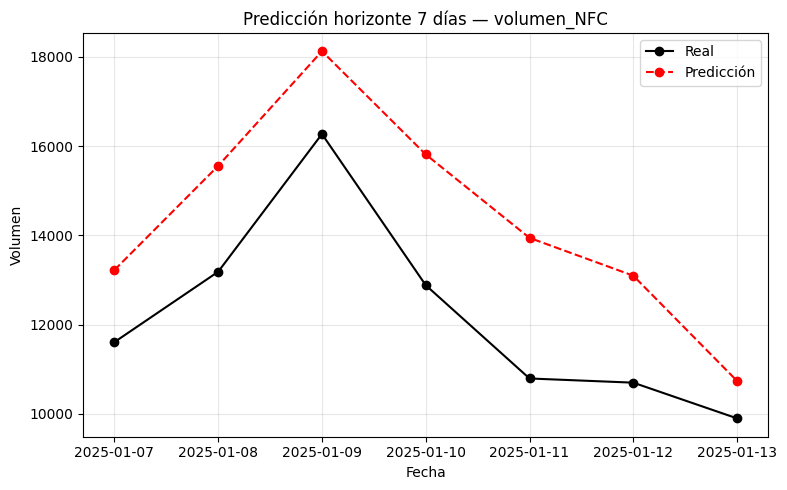

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(target_dates, y_true, marker='o', label="Real", color='black')
plt.plot(target_dates, y_pred, marker='o', linestyle='--', label="Predicción", color='red')
plt.title(f"Predicción horizonte {H} días — {TARGET_COL}")
plt.xlabel("Fecha"); plt.ylabel("Volumen")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

NFP => {'n_lags': 12,
 'learning_rate': 0.028482510657726893,
 'epochs': 200,
 'batch_size': 64,
 'n_changepoints': 20,
 'changepoints_range': 0.7787823562384333}